In [3]:
from keras import models,layers
from keras.preprocessing.image import load_img,img_to_array

In [4]:
target_image_path='F:\\study\\ml\\DataSet\\StyleTransform\\portrait.jpg'
style_reference_image_path='F:\\study\\ml\\DataSet\\StyleTransform\\transfer_style_reference.jpg'

In [5]:
width,height,=load_img(target_image_path).size
img_height=400
img_width=int(width*img_height/height)

In [6]:
import numpy as np
from keras.applications import vgg19

In [7]:
def preprocess_image(image_path):
    img=load_img(image_path,target_size=(img_height,img_width))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=vgg19.preprocess_input(img)
    return img

In [31]:
def deprocess_image(x):
    x[:,:,0]+=103.939
    x[:,:,1]+=116.779
    x[:,:,2]+=123.68
    x=x[:,:,::-1]
    x=np.clip(x,0,255).astype('uint8')
    return x

In [9]:
from keras import backend as K

In [10]:
target_image=K.constant(preprocess_image(target_image_path))
style_reference_image=K.constant(preprocess_image(style_reference_image_path))
combination_image=K.placeholder((1,img_height,img_width,3))

input_tensor=K.concatenate([target_image,style_reference_image,combination_image],
                          axis=0)

model=vgg19.VGG19(input_tensor=input_tensor,weights='imagenet',include_top=False)
print('Model load .')

80142336/80134624 [==============================] - 44s 1us/step
Model load .


In [11]:
def content_loss(base,combination):
    return K.sum(K.square(combination-base))

In [16]:
def gram_matrix(x):
    features=K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    gram=K.dot(features,K.transpose(features))
    return gram

def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=img_height * img_width
    return K.sum(K.square(S-C))/(4.*(channels **2) * (size **2))

In [19]:
def total_variation_loss(x):
    a=K.square(
    x[:,:img_height-1,:img_width-1,:]-x[:,1:,:img_width-1,:])
    b=K.square(
    x[:,:img_height-1,:img_width-1,:]-x[:,:img_height-1,1:,:])
    return K.sum(K.pow(a+b,1.25))

In [20]:
outputs_dict=dict([(layer.name,layer.output) for layer in model.layers])
content_layer='block5_conv2'
style_layers=['block1_conv1',
              'block2_conv1',
              'block3_conv1',
              'block4_conv1',
              'block5_conv1'
             ]
total_variation_weight=1e-4
style_weight=1.
content_weight=0.025

loss=K.variable(0.)
layer_features=outputs_dict[content_layer]
target_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss+=content_weight * content_loss(target_image_features,combination_features)

for layer_name in style_layers:
    layer_features=outputs_dict[layer_name]
    style_reference_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    s1=style_loss(style_reference_features,combination_features)
    loss+=(style_weight / len(style_layers))*s1
loss+=total_variation_weight* total_variation_loss(combination_image)



In [28]:
grads=K.gradients(loss,combination_image)[0]
fetch_loss_and_grads=K.function([combination_image],[loss,grads])

class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
        
    def loss(self,x):
        assert self.loss_value is None
        x=x.reshape((1,img_height,img_width,3))
        outs=fetch_loss_and_grads([x])
        loss_value=outs[0]
        grads_values=outs[1].flatten().astype('float64')
        self.loss_value=loss_value
        self.grads_values=grads_values
        return self.loss_value
    
    def grads(self,x):
        assert self.loss_value is not None
        grads_values=np.copy(self.grads_values)
        self.loss_value=None
        self.grads_values=None
        return grads_values
evaluator=Evaluator()

In [26]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

In [33]:
result_prefix='style_transfer_result'
iterations=20

x=preprocess_image(target_image_path)
x=x.flatten()

for i in range(iterations):
    print('start of iteration',i)
    start_time = time.time()
    x,min_val,info=fmin_l_bfgs_b(evaluator.loss,
                                x,
                                fprime=evaluator.grads,
                                maxfun=20)
    print('Current loss value:',min_val)
    img=x.copy().reshape((img_height,img_width,3))
    img=deprocess_image(img)
    fname=result_prefix+'_at_iteration_%d.png' % i
    imsave(fname,img)
    print('image saved as ',fname)
    end_time=time.time()
    print('Iteration %d completed in %ds' % (i,end_time-start_time))

start of iteration 0
Current loss value: 755671940.0
image saved as  style_transfer_result_at_iteration_0.png
Iteration 0 completed in 258s
start of iteration 1


d:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 250470020.0
image saved as  style_transfer_result_at_iteration_1.png
Iteration 1 completed in 251s
start of iteration 2
Current loss value: 136061220.0
image saved as  style_transfer_result_at_iteration_2.png
Iteration 2 completed in 239s
start of iteration 3
Current loss value: 101902456.0
image saved as  style_transfer_result_at_iteration_3.png
Iteration 3 completed in 238s
start of iteration 4
Current loss value: 85911640.0
image saved as  style_transfer_result_at_iteration_4.png
Iteration 4 completed in 249s
start of iteration 5
Current loss value: 75758950.0
image saved as  style_transfer_result_at_iteration_5.png
Iteration 5 completed in 251s
start of iteration 6
Current loss value: 68005730.0
image saved as  style_transfer_result_at_iteration_6.png
Iteration 6 completed in 250s
start of iteration 7
Current loss value: 62264064.0
image saved as  style_transfer_result_at_iteration_7.png
Iteration 7 completed in 250s
start of iteration 8
Current loss value: 5809

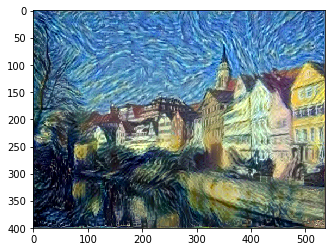

In [35]:
from matplotlib import pyplot as plt

plt.imshow(load_img(target_image_path,target_size=(img_height,img_width)))
plt.imshow(load_img(style_reference_image_path,target_size=(img_height,img_width)))

plt.imshow(img)